In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=512,size=512):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetClean/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=32)

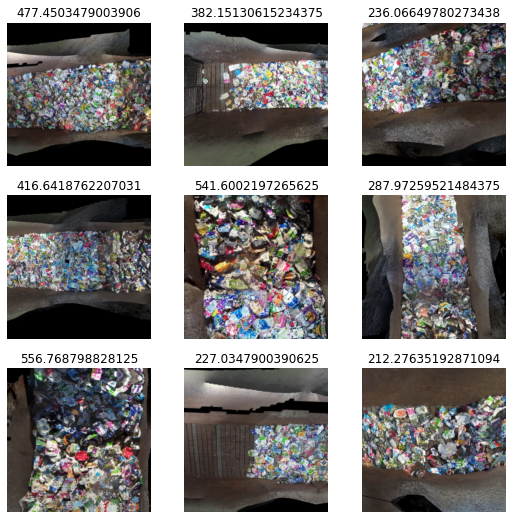

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnet50Masav2')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = cnn_learner(dls,resnet50,loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,105033.296875,125899.148438,285.212799,354.822693,125899.148438,00:07


Better model found at epoch 0 with valid_loss value: 125899.1484375.


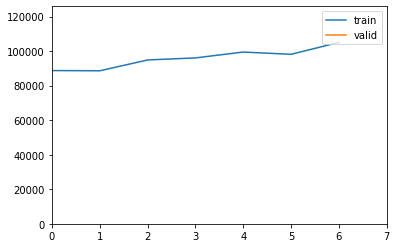

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,104340.234375,125853.726562,285.041718,354.758698,125853.726562,00:06
1,105567.843750,142209.968750,353.200500,377.107361,142209.968750,00:05
2,103700.257812,130148.390625,335.178528,360.760864,130148.390625,00:05
3,101317.546875,111763.289062,300.299652,334.310181,111763.289062,00:05
4,99112.554688,107199.664062,300.135498,327.413574,107199.664062,00:05
5,97000.226562,92094.359375,277.613739,303.470520,92094.359375,00:05
6,94353.375000,91466.414062,272.544586,302.434143,91466.414062,00:05
7,92043.039062,83600.734375,263.429535,289.137909,83600.734375,00:05
8,89140.625000,80609.710938,268.215027,283.918488,80609.710938,00:05
9,87167.679688,93242.078125,287.869385,305.355621,93242.078125,00:05


Better model found at epoch 0 with valid_loss value: 125853.7265625.


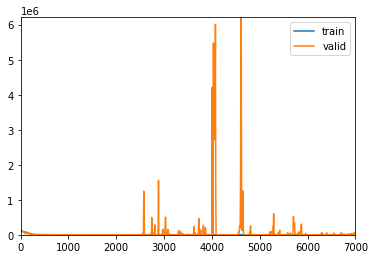

Better model found at epoch 3 with valid_loss value: 111763.2890625.
Better model found at epoch 4 with valid_loss value: 107199.6640625.
Better model found at epoch 5 with valid_loss value: 92094.359375.
Better model found at epoch 6 with valid_loss value: 91466.4140625.
Better model found at epoch 7 with valid_loss value: 83600.734375.
Better model found at epoch 8 with valid_loss value: 80609.7109375.
Better model found at epoch 10 with valid_loss value: 66857.578125.
Better model found at epoch 11 with valid_loss value: 49739.1484375.
Better model found at epoch 12 with valid_loss value: 36590.5078125.
Better model found at epoch 18 with valid_loss value: 33866.015625.
Better model found at epoch 20 with valid_loss value: 33743.515625.
Better model found at epoch 21 with valid_loss value: 29955.939453125.
Better model found at epoch 25 with valid_loss value: 25856.630859375.
Better model found at epoch 28 with valid_loss value: 21062.115234375.
Better model found at epoch 29 with v

In [20]:
learn.fine_tune(1000,base_lr=3e-2)

In [21]:
# learn.load('resnetrs50Masav2')

In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=16)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 41.008304595947266.


(#4) [4774.5625,41.008304595947266,69.09820556640625,4774.5625]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

39.08699